# Sample Material Generation Code

In [16]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy import interpolate
import mitsuba as mi
import config
import os

mi.set_variant('scalar_spectral')

#set wavelength range, increments by 10
nm = np.arange(300,801,10)

outputDir = '../../data/outputs/opticalMaterials/'
os.makedirs(outputDir,exist_ok=True)

In [17]:
outputDir

'../../data/outputs/opticalMaterials/'

We are creating "materials" in the form of .spd files containing the spectral distribution of the absorption and scattering coefficients (converted to extinction and albedo coefficients) to be read by the Mitsuba 3 renderer.

# Creation of Epidermis Materials

Volume fraction of melanosomes estimates in 650-800nm range, assuming a 60um epidermal thickness is as follows:

1.3-6.3% for light skinned adults,
11-16% for moderately pigmented adults,
18-43% for darkly pigmented adults.

We have arbitrarily chosen the values in the melanosomes list; **adjust the melanosomes list below to create more skintones as needed.**

In [18]:
# Reduced scattering coefficient of epidermis (inverse cm)
musEpi = 68.7*(nm/500)**(-1.161)
adict = {'wavelength':nm, 'rScattering':musEpi}
df_musEpi = pandas.DataFrame(adict)
df_musEpi.to_csv(outputDir + '/epidermis_rScattering.spd', sep = ' ', header=False, index=False)

#refractive index for epidermis between 1.42-1.44
iorEpi = 1.43

#melanosome absorption coefficient (inverse cm)
muaMel = 6.6e11 * nm**(-3.33)

melanosomes = [float(x) / 100 for x in range(1, 51)]
muaEpi = {}
df_muaEpi = {}
for mel in melanosomes:
    #absorption coefficient of epidermis (inverse cm)
    muaEpi[mel] = mel * muaMel + (1-mel)*(0.244 + 85.3 * np.exp(-(nm-154)/66.2))
    adict = {'wavelength':nm, 'absorption':muaEpi[mel]}
    df_muaEpi[mel] = pandas.DataFrame(adict)
    df_muaEpi[mel].to_csv(outputDir + '/epidermis_abs_mel' + str(mel) + '.spd', sep = ' ', header=False, index=False)
    
    #extinction coefficient = absorption + scattering
    extEpi = muaEpi[mel] + musEpi
    adict = {'wavelength':nm, 'extinction':extEpi}
    df_extEpi = pandas.DataFrame(adict)
    df_extEpi.to_csv(outputDir + '/epidermis_ext_mel' + str(mel) + '.spd', sep = ' ', header=False, index=False)
    
    #albedo = scattering / extinction coefficient
    albEpi = musEpi/extEpi
    adict = {'wavelength':nm, 'albedo':albEpi}
    df_albEpi = pandas.DataFrame(adict)
    df_albEpi.to_csv(outputDir + '/epidermis_alb_mel' + str(mel) + '.spd', sep = ' ', header=False, index=False)

# Creation of Blood Material

The optical coefficients (absorption, scattering, extinction, albedo) of blood must be computed before calculating the optical coefficients of the dermis layer. According to literature (Bencha, Ciaran et al. "Towards accurate quantitative photoacoustic imaging: learning vascular blood oxygen saturation in 3D"), the optical absorption of blood is a combination of the molar concentration multiplied by the absorbance of BOTH the oxygenated and de-oxygenated hemoglobin. However, we deviated from this equation because we do not know the ratio of the concentration of oxygenated vs. de-oxygenated hemoglobin (in literature, we only found concentration of whole blood). So, although we calculate for the optical coefficients of both oxygenated and de-oxygenated hemoglobin in the line below, we are currently only using the oxygenated hemoglobin in the rendering of blood (and subsequently the dermis material). If we figure out the ratio in the future, we already have the materials to go with it.

The tabulated molar extinction coefficients are from well-known documentation (Jacques, Steven L. "Tabulated Molar Extinction Coefficient for Hemoglobin in Water"). We also get the relationship between the molar exctinction coefficients and the absorbance to the absorption from this reference (omlc.org/spectra/hemoglobin/summary.html)

Lastly, the absorption coefficient of whole blood is assuming hemoglobin concentration of 150g/liter. This value is gender/age/condition-dependent (138-172 g/L for men; 121-151 g/L for women; 110-160 g/L for children; 110-120 g/L for pregnant women; low hemoglobin for diseases such as iron deficiency anemia, kidney disease, liver disease, chemo/radiation treatment; high hemoglobin for diseases such as dehydration, smoking, heart failure, kidney cancer, chronic lung disease). At the current time, we do not believe it will make a big difference in the renderings.

In [19]:
#import tabulated molar extinction coefficients for deoxy-hemoglobin in water for 300-800nm in 10nm increments
df_molarExtHb = pandas.read_csv (config.sDir + '/opticalMaterials/Hb_molarExtinction_valuesOnly.spd', header = None)
molarExtHb = np.squeeze(np.array(df_molarExtHb))
#import tabulated molar extinction coefficients for oxy-hemoglobin in water for 300-800nm in 10nm increments
df_molarExtHbO2 = pandas.read_csv (config.sDir + '/opticalMaterials/HbO2_molarExtinction_valuesOnly.spd', header = None)
molarExtHbO2 = np.squeeze(np.array(df_molarExtHbO2))

#absorption coefficient of whole blood assuming Hb concentration = 150g/liter
#64500g/mole is the gram molecular weight of Hb
muaHb = 2.303 * molarExtHb * 150 / 64500
adict = {'wavelength':nm, 'absorption':muaHb}
df_muaHb = pandas.DataFrame(adict)
df_muaHb.to_csv(outputDir + '/blood_Hb_absorption' + '.spd', sep = ' ', header=False, index=False)

muaHbO2 = 2.303 * molarExtHbO2 * 150 / 64500
adict = {'wavelength':nm, 'absorption':muaHbO2}
df_muaHbO2 = pandas.DataFrame(adict)
df_muaHbO2.to_csv(outputDir + '/blood_HbO2_absorption' + '.spd', sep = ' ', header=False, index=False)

#reduced scattering coefficient of whole blood (inverse cm)
musBlood = 22*(nm/500)**(-0.66)
adict = {'wavelength':nm, 'absorption':musBlood}
df_musBlood = pandas.DataFrame(adict)
df_musBlood.to_csv(outputDir + '/blood_rScattering' + '.spd', sep = ' ', header=False, index=False)

#extinction coefficient = absorption + scattering
extHb = muaHb + musBlood
adict = {'wavelength':nm, 'extinction':extHb}
df_extHb = pandas.DataFrame(adict)
df_extHb.to_csv(outputDir + '/blood_Hb_ext' + '.spd', sep = ' ', header=False, index=False)

extHbO2 = muaHbO2 + musBlood
adict = {'wavelength':nm, 'extinction':extHbO2}
df_extHbO2 = pandas.DataFrame(adict)
df_extHbO2.to_csv(outputDir + '/blood_HbO2_ext' + '.spd', sep = ' ', header=False, index=False)

#albedo = scattering / extinction coefficient
albHb = musBlood/extHb
adict = {'wavelength':nm, 'albedo':albHb}
df_albHb = pandas.DataFrame(adict)
df_albHb.to_csv(outputDir + '/blood_Hb_alb' + '.spd', sep = ' ', header=False, index=False)

albHbO2 = musBlood/extHbO2
adict = {'wavelength':nm, 'albedo':albHbO2}
df_albHbO2 = pandas.DataFrame(adict)
df_albHbO2.to_csv(outputDir + '/blood_HbO2_alb' + '.spd', sep = ' ', header=False, index=False)
    
#refractive index for blood = 1.36 for 680-930nm
iorBlood = 1.36

# Creation of Dermis Materials

Volume fraction of blood in the dermis layer ranges from 0.2-7%:

0.2% is typical in most areas of the skin,
concentrated range of 2-5% in venous plexus.

We have arbitrarily chosen the values in the blood fraction list; **adjust the fractionBlood list below to create more variations of blood present in skintones as needed.**

In [20]:
#reduced scattering coefficient of dermis (inverse cm)
musDerm = 45.3*(nm/500)**(-1.292)
adict = {'wavelength':nm, 'rScattering':musDerm}
df_musDerm = pandas.DataFrame(adict)
df_musDerm.to_csv(outputDir + '/dermis_rScattering.spd', sep = ' ', header=False, index=False)

#refractive index for dermis is wavelength-dependent, but cannot input spectrum for ior in bsdf
#therefore, will normalize to lambda = 500nm
A = 1.3696
B = 3916.8
C = 2558.8
iorDerm = A + (B/(500**2)) + (C/(500**4))

#fB = volume fraction of blood; range = 0.2-7%
#fB = typical 0.2%; concentrated in venous plexus 2-5%
fractionBlood = [0.002, 0.005, 0.02, 0.05]
muaDerm = {}
df_muaDerm = {}
for fB in fractionBlood:
    #absorption coefficient of dermis (inverse cm)
    muaDerm[fB] = fB * muaHbO2 + (1-fB)*(0.244 + 85.3 * np.exp(-(nm-154)/66.2))
    adict = {'wavelength':nm, 'absorption':muaDerm[fB]}
    df_muaDerm[fB] = pandas.DataFrame(adict)
    df_muaDerm[fB].to_csv(outputDir + '/dermis_abs_fB' + str(fB) + '.spd', sep = ' ', header=False, index=False)
    
    #extinction coefficient = absorption + scattering
    extDerm = muaDerm[fB] + musDerm
    adict = {'wavelength':nm, 'extinction':extDerm}
    df_extDerm = pandas.DataFrame(adict)
    df_extDerm.to_csv(outputDir + '/dermis_ext_fB' + str(fB) + '.spd', sep = ' ', header=False, index=False)
    
    #albedo = scattering / extinction coefficient
    albDerm = musDerm/extDerm
    adict = {'wavelength':nm, 'albedo':albDerm}
    df_albDerm = pandas.DataFrame(adict)
    df_albDerm.to_csv(outputDir + '/dermis_alb_fB' + str(fB) + '.spd', sep = ' ', header=False, index=False)

# Creation of Hypodermis Material

In [21]:
#absorption coefficient of hypodermis (inverse cm)
muaHypo = ((-1/600)*nm) + (143/60)
adict = {'wavelength':nm, 'absorption':muaHypo}
df_muaHypo = pandas.DataFrame(adict)
df_muaHypo.to_csv(outputDir + '/hypo_absorption' + '.spd', sep = ' ', header=False, index=False)

#reduced scattering coefficient of hypodermis (inverse cm)
musHypo = ((-11/600)*nm) + (1687/60)
adict = {'wavelength':nm, 'absorption':musHypo}
df_musHypo = pandas.DataFrame(adict)
df_musHypo.to_csv(outputDir + '/hypo_rScattering' + '.spd', sep = ' ', header=False, index=False)

#extinction coefficient = absorption + scattering
extHypo = muaHypo + musHypo
adict = {'wavelength':nm, 'extinction':extHypo}
df_extHypo = pandas.DataFrame(adict)
df_extHypo.to_csv(outputDir + '/hypo_ext' + '.spd', sep = ' ', header=False, index=False)

#albedo = scattering / extinction coefficient
albHypo = musHypo/extHypo
adict = {'wavelength':nm, 'albedo':albHypo}
df_albHypo = pandas.DataFrame(adict)
df_albHypo.to_csv(outputDir + '/hypo_alb' + '.spd', sep = ' ', header=False, index=False)

#refractive index for hypodermis
iorHypo = 1.44

# Creation of Melanoma Material from a published figure

Data points from absorption and scattering plots were extracted from Figure 3 of Garcia-Uribe 2011 paper "In-vivo characterization of optical properties of pigmented skin lesions including melanoma" using WebPlotDigitizer. In this paper, the authors used oblique incidence diffuse reflectance spectrometry to conduct in-vivo measurements of optical properties of melanoma.

The wavelength range extracted from these plots (460-760) is smaller than those of the previous materials we've created so far. So, if we were to render beyond the visible spectrum (i.e. uv, infrared, other hyperspectral ranges) this current material would not be sufficient for those renderings. On the other hand, we can adjust the wavelength range of our other materials on ln [1] above.

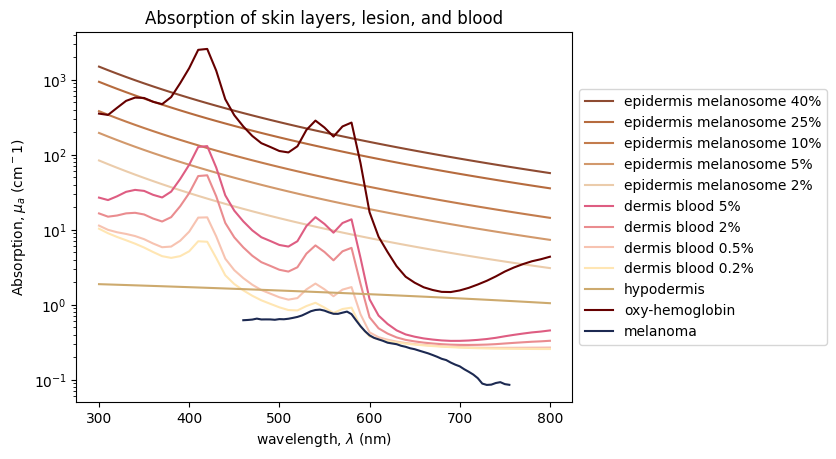

In [24]:
#set wavelength range, increments by 5
lesion_nm = np.arange(460,760,5)

#import extracted data points from figure 3 of Garcia-Uribe 2011 paper
lesion_rScat = mi.spectrum_from_file(config.sDir + "opticalMaterials/melanoma_rScattering.spd")
lesion_absorb = mi.spectrum_from_file(config.sDir + "opticalMaterials/melanoma_absorption.spd")

#linear interpolation of data points and export to spd
interp_rScat = interpolate.interp1d(lesion_rScat[0],lesion_rScat[1])
musLesion = interp_rScat(lesion_nm)
adict = {'wavelength':lesion_nm, 'rScattering':musLesion}
df_musLesion = pandas.DataFrame(adict)
df_musLesion.to_csv(outputDir + '/melanoma_rScattering_interp.spd', sep = ' ', header=False, index=False)

interp_absorb = interpolate.interp1d(lesion_absorb[0],lesion_absorb[1])
muaLesion = interp_absorb(lesion_nm)
adict = {'wavelength':lesion_nm, 'absorption':muaLesion}
df_muaLesion = pandas.DataFrame(adict)
df_muaLesion.to_csv(outputDir + '/melanoma_absorption_interp.spd', sep = ' ', header=False, index=False)

#extinction coefficient = absorption + scattering
extLesion = muaLesion + musLesion
adict = {'wavelength':lesion_nm, 'extinction':extLesion}
df_extLesion = pandas.DataFrame(adict)
df_extLesion.to_csv(outputDir + '/melanoma_ext.spd', sep = ' ', header=False, index=False)

#albedo = scattering / extinction coefficient
albLesion = musLesion/extLesion
adict = {'wavelength':lesion_nm, 'albedo':albLesion}
df_albLesion = pandas.DataFrame(adict)
df_albLesion.to_csv(outputDir + 'melanoma_alb.spd', sep = ' ', header=False, index=False)

#refractive index formula for melanoma is wavelength-dependent (2019 Shirkavand), but cannot input spectrum for ior in bsdf
#therefore, will normalize to lambda = 500nm
iorLesion = 1.32988 - (-3.97577e7) * 0.95902**(500)

plt.plot(nm, muaEpi[0.4], color='#8E4B32', label='epidermis melanosome 40%')
plt.plot(nm, muaEpi[0.25], color='#B66B3E', label='epidermis melanosome 25%')
plt.plot(nm, muaEpi[0.1], color='#C37C4D', label='epidermis melanosome 10%')
plt.plot(nm, muaEpi[0.05], color='#D2996C', label='epidermis melanosome 5%')
plt.plot(nm, muaEpi[0.02], color='#EBCCAB', label='epidermis melanosome 2%')
plt.plot(nm, muaDerm[0.05], color='#DE5D82', label='dermis blood 5%')
plt.plot(nm, muaDerm[0.02], color='#EA8C8F', label='dermis blood 2%')
plt.plot(nm, muaDerm[0.005], color='#F7C3B1', label='dermis blood 0.5%')
plt.plot(nm, muaDerm[0.002], color='#FFE6B3', label='dermis blood 0.2%')
plt.plot(nm, muaHypo, color='#CDAA6E', label='hypodermis')
plt.plot(nm, muaHbO2, color='#660000', label='oxy-hemoglobin')
plt.plot(lesion_nm, muaLesion, color='#1C2951', label='melanoma')
plt.title("Absorption of skin layers, lesion, and blood")
plt.xlabel("wavelength, $\lambda$ (nm)")
plt.ylabel("Absorption, $\mu_{a}$ (cm$^-1$)")
plt.yscale("log")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Creation of New Melanoma Material #1

From here on out, the melanoma material obtained from literature above will be referred to as old melanoma.

New optical material #1 using old melanoma material + dermis (blood fraction 0.2%) material + epidermis (melanosome fraction 40%) material.

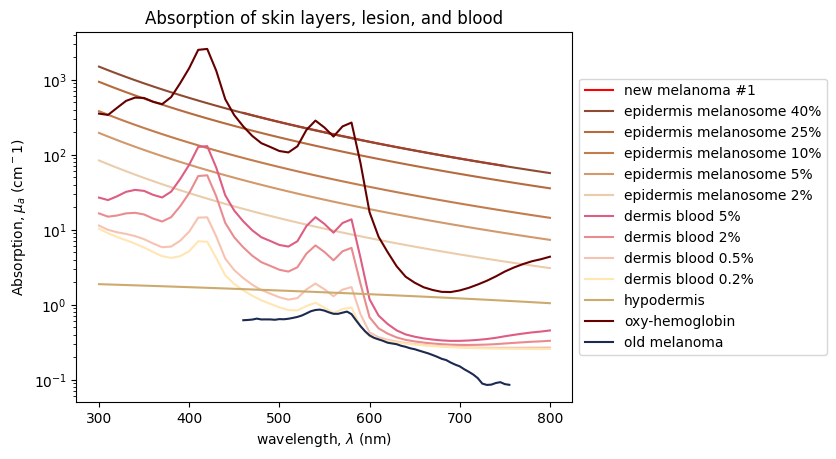

In [25]:
# Merge the dataframes
meraDermisLesion = pandas.merge(df_muaLesion, df_muaDerm[0.002], on='wavelength')
meraDermisEpiLesion = pandas.merge(meraDermisLesion, df_muaEpi[0.4], on='wavelength')

# Add the values in the merged columns
meraDermisEpiLesion['mer_absorption'] = meraDermisEpiLesion['absorption_x'] + meraDermisEpiLesion['absorption_y'] + meraDermisEpiLesion['absorption']

# Export the merged column as a NumPy ndarray
muaDermisEpiLesion = meraDermisEpiLesion['mer_absorption'].values
merged_nm = meraDermisEpiLesion['wavelength'].values

# do the same for reduced scattering
mersDermisLesion = pandas.merge(df_musLesion, df_musDerm, on='wavelength')
mersDermisEpiLesion = pandas.merge(mersDermisLesion, df_musEpi, on='wavelength')
mersDermisEpiLesion['mer_rScattering'] = mersDermisEpiLesion['rScattering_x'] + mersDermisEpiLesion['rScattering_y'] + mersDermisEpiLesion['rScattering']
musDermisEpiLesion = mersDermisEpiLesion['mer_rScattering'].values

# export to spd
adict = {'wavelength':merged_nm, 'mer_absorption':muaDermisEpiLesion}
df_muaDermisEpiLesion = pandas.DataFrame(adict)
df_muaDermisEpiLesion.to_csv(outputDir + '/melDermEpi_absorption.spd', sep = ' ', header=False, index=False)

adict = {'wavelength':merged_nm, 'mer_rScattering':musDermisEpiLesion}
df_musDermisEpiLesion = pandas.DataFrame(adict)
df_musDermisEpiLesion.to_csv(outputDir + '/melDermEpi_rScattering.spd', sep = ' ', header=False, index=False)

#extinction coefficient = absorption + scattering
extDermisEpiLesion = muaDermisEpiLesion + musDermisEpiLesion
adict = {'wavelength':merged_nm, 'mer_extinction':extDermisEpiLesion}
df_extDermisEpiLesion = pandas.DataFrame(adict)
df_extDermisEpiLesion.to_csv(outputDir + '/melDermEpi_ext.spd', sep = ' ', header=False, index=False)

#albedo = scattering / extinction coefficient
albDermisEpiLesion = musDermisEpiLesion/extDermisEpiLesion
adict = {'wavelength':merged_nm, 'mer_albedo':albDermisEpiLesion}
df_albDermisEpiLesion = pandas.DataFrame(adict)
df_albDermisEpiLesion.to_csv(outputDir + '/melDermEpi_alb.spd', sep = ' ', header=False, index=False)

#refractive index formula for melanoma is wavelength-dependent (2019 Shirkavand), but cannot input spectrum for ior in bsdf
#therefore, will normalize to lambda = 500nm
iorLesion = 1.32988 - (-3.97577e7) * 0.95902**(500)

plt.plot(merged_nm, muaDermisEpiLesion, color='red', label='new melanoma #1')
plt.plot(nm, muaEpi[0.4], color='#8E4B32', label='epidermis melanosome 40%')
plt.plot(nm, muaEpi[0.25], color='#B66B3E', label='epidermis melanosome 25%')
plt.plot(nm, muaEpi[0.1], color='#C37C4D', label='epidermis melanosome 10%')
plt.plot(nm, muaEpi[0.05], color='#D2996C', label='epidermis melanosome 5%')
plt.plot(nm, muaEpi[0.02], color='#EBCCAB', label='epidermis melanosome 2%')
plt.plot(nm, muaDerm[0.05], color='#DE5D82', label='dermis blood 5%')
plt.plot(nm, muaDerm[0.02], color='#EA8C8F', label='dermis blood 2%')
plt.plot(nm, muaDerm[0.005], color='#F7C3B1', label='dermis blood 0.5%')
plt.plot(nm, muaDerm[0.002], color='#FFE6B3', label='dermis blood 0.2%')
plt.plot(nm, muaHypo, color='#CDAA6E', label='hypodermis')
plt.plot(nm, muaHbO2, color='#660000', label='oxy-hemoglobin')
plt.plot(lesion_nm, muaLesion, color='#1C2951', label='old melanoma')
plt.title("Absorption of skin layers, lesion, and blood")
plt.xlabel("wavelength, $\lambda$ (nm)")
plt.ylabel("Absorption, $\mu_{a}$ (cm$^-1$)")
plt.yscale("log")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Creation of New Melanoma Material #2

New optical material #2 using (blood material x multiplier) + epidermis (all melanosome fractions) material.

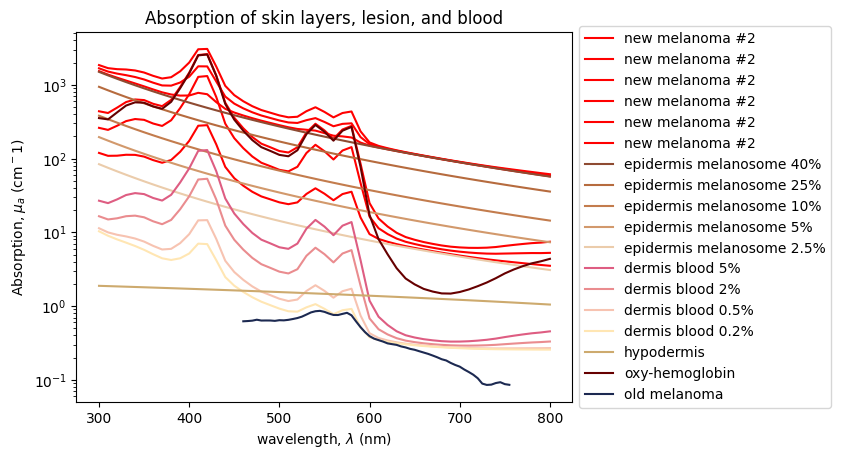

In [26]:
multiplier = [0.1, 0.5, 1.0]
muaHbx = {}
muaHbO2x = {}
musBloodx = {}
df_muaHbx = {}
df_muaHbO2x = {}
df_musBloodx = {}

musBloodEpi = {}
muaBloodEpi = {}
df_muaBloodEpi = {}

for mult in multiplier:
    
    muaBloodEpi[mult] = {}
    df_muaBloodEpi[mult] = {}
    
    #absorption coefficient times multiplier
    muaHbx[mult] = (2.303 * molarExtHb * 150 / 64500) * mult
    adict = {'wavelength':nm, 'absorption':muaHbx[mult]}
    df_muaHbx[mult] = pandas.DataFrame(adict)
    df_muaHbx[mult].to_csv(outputDir + '/bloodx' + str(mult) + '_Hb_absorption' + '.spd', sep = ' ', header=False, index=False)
    
    muaHbO2x[mult] = (2.303 * molarExtHbO2 * 150 / 64500) * mult
    adict = {'wavelength':nm, 'absorption':muaHbO2x[mult]}
    df_muaHbO2x[mult] = pandas.DataFrame(adict)
    df_muaHbO2x[mult].to_csv(outputDir + 'bloodx' + str(mult) + '_HbO2_absorption' + '.spd', sep = ' ', header=False, index=False)
    
    #reduced scattering coefficient of whole blood (inverse cm)
    musBloodx[mult] = (22*(nm/500)**(-0.66)) * mult
    adict = {'wavelength':nm, 'absorption':musBloodx[mult]}
    df_musBloodx[mult] = pandas.DataFrame(adict)
    df_musBloodx[mult].to_csv(outputDir + '/bloodx' + str(mult) + '_rScattering' + '.spd', sep = ' ', header=False, index=False)
    
    # Merge dataframes for reduced scattering and export to spd
    mersBloodEpi = pandas.merge(df_musBloodx[mult], df_musEpi, on='wavelength')
    mersBloodEpi['mer_rScattering'] = mersBloodEpi['absorption'] + mersBloodEpi['rScattering']
    musBloodEpi[mult] = mersBloodEpi['mer_rScattering'].values

    adict = {'wavelength':nm, 'mer_rScattering':musBloodEpi[mult]}
    df_musBloodEpi = pandas.DataFrame(adict)
    df_musBloodEpi.to_csv(outputDir + '/HbO2x' + str(mult) + 'Epi_rScattering.spd', sep = ' ', header=False, index=False)

    for mel in melanosomes:
        
        # Merge the dataframes for absorption
        meraBloodEpi = pandas.merge(df_muaHbO2x[mult], df_muaEpi[mel], on='wavelength')
        
        # Add the values in the merged columns
        meraBloodEpi['mer_absorption'] = meraBloodEpi['absorption_x'] + meraBloodEpi['absorption_y']

        # Export the merged column as a NumPy ndarray
        muaBloodEpi[mult][mel] = meraBloodEpi['mer_absorption'].values
        merged_nm = meraBloodEpi['wavelength'].values

        # export to spd
        adict = {'wavelength':merged_nm, 'mer_absorption':muaBloodEpi[mult][mel]}
        df_muaBloodEpi[mult][mel] = pandas.DataFrame(adict)
        df_muaBloodEpi[mult][mel].to_csv(outputDir + '/HbO2x' + str(mult) + 'Epix' + str(mel) + '_absorption.spd', sep = ' ', header=False, index=False)
        
        #extinction coefficient = absorption + scattering
        extBloodEpi = muaBloodEpi[mult][mel] + musBloodEpi[mult]
        adict = {'wavelength':nm, 'extinction':extBloodEpi}
        df_extBloodEpi = pandas.DataFrame(adict)
        df_extBloodEpi.to_csv(outputDir + '/HbO2x' + str(mult) + 'Epix' + str(mel) + '_ext' + '.spd', sep = ' ', header=False, index=False)
        
        #albedo = scattering / extinction coefficient
        albBloodEpi = musBloodEpi[mult]/extBloodEpi
        adict = {'wavelength':nm, 'albedo':albBloodEpi}
        df_albBloodEpi = pandas.DataFrame(adict)
        df_albBloodEpi.to_csv(outputDir + '/HbO2x' + str(mult) + 'Epix' + str(mel) + '_alb' + '.spd', sep = ' ', header=False, index=False)
    
plt.plot(nm, muaBloodEpi[0.1][0.02], color='red', label='new melanoma #2')
plt.plot(nm, muaBloodEpi[0.1][0.4], color='red', label='new melanoma #2')
plt.plot(nm, muaBloodEpi[0.5][0.02], color='red', label='new melanoma #2')
plt.plot(nm, muaBloodEpi[0.5][0.4], color='red', label='new melanoma #2')
plt.plot(nm, muaBloodEpi[1.0][0.02], color='red', label='new melanoma #2')
plt.plot(nm, muaBloodEpi[1.0][0.4], color='red', label='new melanoma #2')
plt.plot(nm, muaEpi[0.4], color='#8E4B32', label='epidermis melanosome 40%')
plt.plot(nm, muaEpi[0.25], color='#B66B3E', label='epidermis melanosome 25%')
plt.plot(nm, muaEpi[0.1], color='#C37C4D', label='epidermis melanosome 10%')
plt.plot(nm, muaEpi[0.05], color='#D2996C', label='epidermis melanosome 5%')
plt.plot(nm, muaEpi[0.02], color='#EBCCAB', label='epidermis melanosome 2.5%')
plt.plot(nm, muaDerm[0.05], color='#DE5D82', label='dermis blood 5%')
plt.plot(nm, muaDerm[0.02], color='#EA8C8F', label='dermis blood 2%')
plt.plot(nm, muaDerm[0.005], color='#F7C3B1', label='dermis blood 0.5%')
plt.plot(nm, muaDerm[0.002], color='#FFE6B3', label='dermis blood 0.2%')
plt.plot(nm, muaHypo, color='#CDAA6E', label='hypodermis')
plt.plot(nm, muaHbO2, color='#660000', label='oxy-hemoglobin')
plt.plot(lesion_nm, muaLesion, color='#1C2951', label='old melanoma')
plt.title("Absorption of skin layers, lesion, and blood")
plt.xlabel("wavelength, $\lambda$ (nm)")
plt.ylabel("Absorption, $\mu_{a}$ (cm$^-1$)")
plt.yscale("log")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()